# Genesis Analysis of Image-X phantom

This notebook demonstrates the use of the Sydney University phantom [described here](https://image-x-institute.github.io/mri_distortion_toolkit/phantom_notes.html) with an Elekta MRI-Unity. All analysed data is available [here](https://zenodo.org/records/10685865). Documentation for the `mri_distortion_toolkit` is [here](https://image-x-institute.github.io/mri_distortion_toolkit/)

## Image Acquisition

The phantoms were imaged on an Elekta Unity system using a 3D spin echo sequence with a bandwidth of 740 Hz. Images were acquired both with and without vendor distortion correction. In addition, images were acquired on a CT scanner.

## Marker Extraction

In [1]:
from pathlib import Path
from mri_distortion_toolkit.MarkerAnalysis import MarkerVolume, MatchedMarkerVolumes
from mri_distortion_toolkit.utilities import plot_distortion_xyz_hist
import numpy as np

# extract CT data (nb: will take a few minutes)
ct_data_loc = r"/home/brendan/Dropbox (Sydney Uni)/Projects/OpenDistortionPhantom/genesis_data/GOAM_CT/2022-08__Studies/ImageX^GOAM_ZZZIMAGEX_CT_2022-08-31_170444_RT^01.Pelvis.Customized.(Adult)_Pelvis..2.0..B31f_n178__00000"
ct_volume = MarkerVolume(ct_data_loc, ImExtension='dcm', n_markers_expected=531, gaussian_image_filter_sd=0)

total segmentation time:  63.5 s


In [2]:
# extract MR data, with distortion correction  (nb: will take a few minutes)
mr_data_loc_with_DC = Path(r"/home/brendan/Dropbox (Sydney Uni)/Projects/OpenDistortionPhantom/genesis_data/GOAM_MRI/2022-08__Studies/GOAM^ImageX_ZZZIMAGEX_MR_2022-08-31_172341_._T2.3D.Tra.2min_n301__00002")
mri_volume_with_DC= MarkerVolume(mr_data_loc_with_DC, r_max=None, n_markers_expected=531)

# extract MR markers, without distortion correction  (nb: will take a few minutes)
mr_data_loc_no_DC = Path(r"/home/brendan/Dropbox (Sydney Uni)/Projects/OpenDistortionPhantom/genesis_data/GOAM_MRI/2022-08__Studies/GOAM^ImageX_ZZZIMAGEX_MR_2022-08-31_172341_._T2.3D.Tra.2min_n301__00001")
mri_volume_no_DC = MarkerVolume(mr_data_loc_no_DC, n_markers_expected=531, r_max=170)

this code has not been tested with non-siemens scanners. If dicom standards work properlythis code will too...
total segmentation time:  97.2 s
this code has not been tested with non-siemens scanners. If dicom standards work properlythis code will too...


[MarkerAnalysis.py: line 150  WARNING] For data /home/brendan/Dropbox (Sydney Uni)/Projects/OpenDistortionPhantom/genesis_data/GOAM_MRI/2022-08__Studies/GOAM^ImageX_ZZZIMAGEX_MR_2022-08-31_172341_._T2.3D.Tra.2min_n301__00001
You entered that you expected to find 531, but actually found 507.


total segmentation time:  93.5 s


# Marker Matching

At this point, we have extracted the markers from all three image series. Becuase we specified the expected number of markers, and got no warnings (apart from the warning from pandas which is a bit annoying...) we can be reasonably confident the extraction went well. However, the real test of this will be the next step, where we try to match the ground truth data to the 

In [3]:
from mri_distortion_toolkit.MarkerAnalysis import MarkerVolume, MatchedMarkerVolumes
from mri_distortion_toolkit.utilities import plot_distortion_xyz_hist
import numpy as np

# create marker volumes (can skip time consumging segmentation step above if data was saved)
# mri_volume_with_DC = MarkerVolume(r'..\_segmentation_data\GOAM_MRI\2022-08__Studies\GOAM^ImageX_ZZZIMAGEX_MR_2022-08-31_172341_._T2.3D.Tra.2min_n301__00002\slicer_centroids.mrk.json')
# mri_volume_no_DC = MarkerVolume(r'..\_segmentation_data\GOAM_MRI\2022-08__Studies\GOAM^ImageX_ZZZIMAGEX_MR_2022-08-31_172341_._T2.3D.Tra.2min_n301__00001\slicer_centroids.mrk.json')
# ct_volume = MarkerVolume(r'..\_segmentation_data\GOAM_CT\slicer_centroids.mrk.json')

# match markers:
no_DC_match = MatchedMarkerVolumes(ct_volume, mri_volume_no_DC, n_refernce_markers=7)
with_DC_match = MatchedMarkerVolumes(ct_volume, mri_volume_with_DC, n_refernce_markers=7)

aligning ground truth centroids by 
x     -2.782971
y    212.128496
z    691.026551
dtype: float64
rotating ground truth centroids by 
[[ 9.99959885e-01  3.95632642e-05 -8.95698658e-03]
 [-4.38895654e-05  9.99999882e-01 -4.82812509e-04]
 [ 8.95696643e-03  4.83186259e-04  9.99959769e-01]]
aligning ground truth centroids by 
x     -2.803910
y    212.210618
z    691.037414
dtype: float64
rotating ground truth centroids by 
[[ 9.99961070e-01  3.60256264e-04 -8.81634197e-03]
 [-3.66952164e-04  9.99999645e-01 -7.57881511e-04]
 [ 8.81606582e-03  7.61087183e-04  9.99960848e-01]]


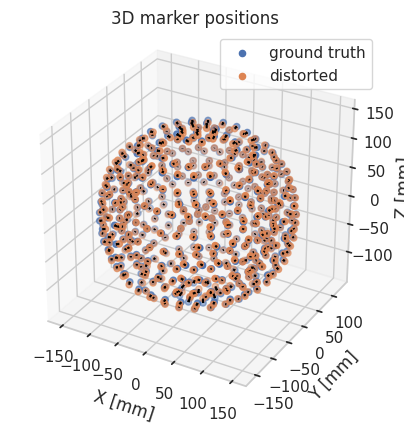

In [4]:
no_DC_match.plot_3D_markers()

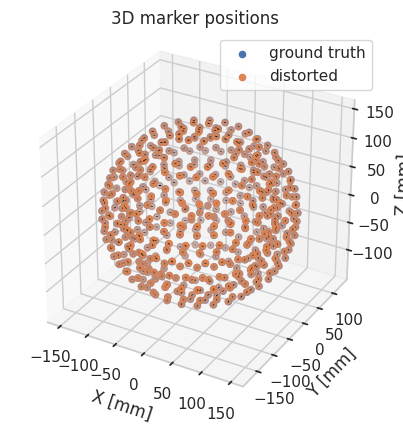

In [5]:
with_DC_match.plot_3D_markers()

In general, you can see that the Philipps distortion correction is excellent. Even with no distortion correction, the distortion in this FOV is quite small. We can get a bit more quantititative about this:

In [6]:
np.median(with_DC_match.MatchedCentroids.match_distance)

0.5899593261604844

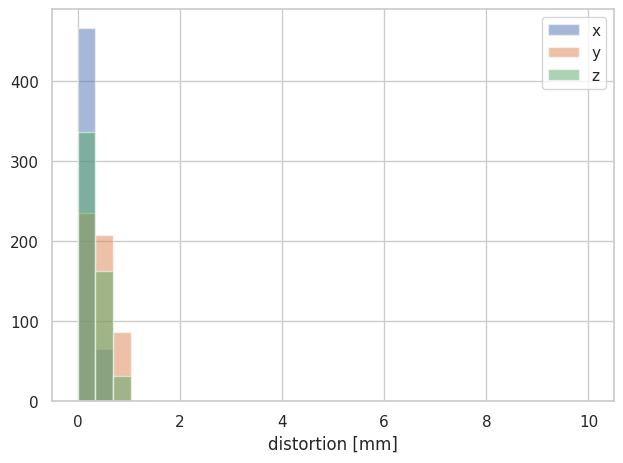

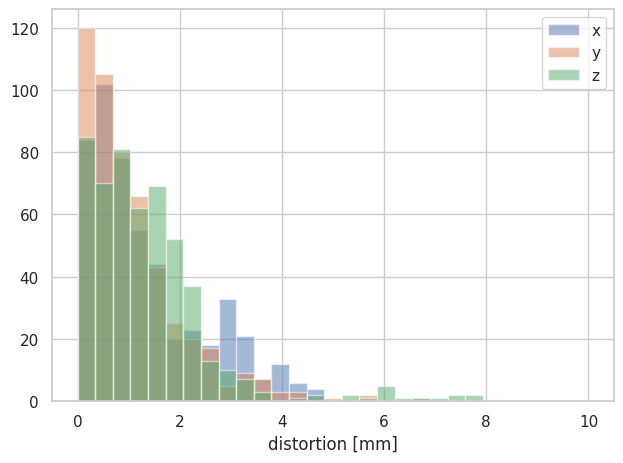

In [7]:
plot_distortion_xyz_hist(with_DC_match)
plot_distortion_xyz_hist(no_DC_match)

## spherical harmonics

Based on these (distorted) marker positions, we can calculate the gradient fields, and characterise these in terms of spherical harmonics. For this to really be interesting, we would need a phantom covering a bigger FOV, but nevertheless:

In [8]:
from mri_distortion_toolkit.FieldCalculation import ConvertMatchedMarkersToBz
from mri_distortion_toolkit import calculate_harmonics

Bz_field = ConvertMatchedMarkersToBz(no_DC_match.MatchedCentroids, mri_volume_no_DC.dicom_data)
gradient_strength = np.array(mri_volume_no_DC.dicom_data['gradient_strength'])
normalisation_factor = [1 / gradient_strength[0], 1 / gradient_strength[1], 1 / gradient_strength[2],
                        1]  # this normalised gradient harmonics to 1mT/m
G_x_Harmonics, G_y_Harmonics, G_z_Harmonics, B0_Harmonics = calculate_harmonics(Bz_field.MagneticFields,
                                                                                n_order=8,
                                                                                scale=normalisation_factor)

Initial pk-pk:        4.250e+03 μT
Reconstructed pk-pk:  4.252e+03 μT
Residual pk-pk:       1.219e+01 μT ( 0.3%)
Initial pk-pk:        3.987e+03 μT
Reconstructed pk-pk:  4.000e+03 μT
Residual pk-pk:       2.625e+01 μT ( 0.7%)
Initial pk-pk:        3.113e+03 μT
Reconstructed pk-pk:  3.114e+03 μT
Residual pk-pk:       3.752e+01 μT ( 1.2%)


The output above indicates:

1. we scaled the harmonics - I scale them to a strength of 1 mT/m so we can easily use them for different sequences
2. The initial peak to peak perturbation in the input fields, the reconstructed peak-peak, and the peak-peak of the residual (initial - reconsttructed) field. Note that the residual is <1% in all cases, indicating a good fit.

Now we have these harmonics, we can make some nice plots and print the dominant harmonics:

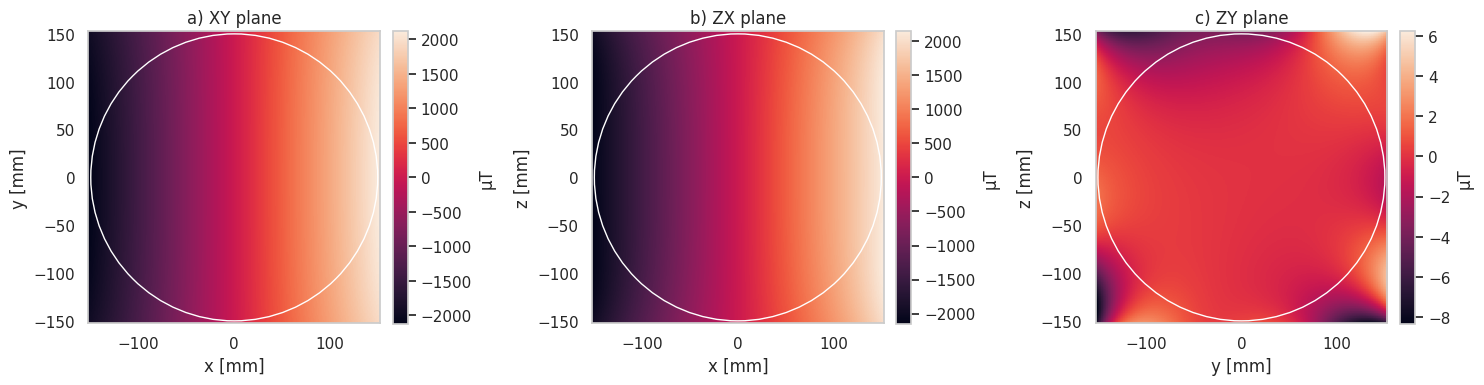

In [9]:
G_x_Harmonics.plot_cut_planes()

Note that this varies in X as expected; in the ZY plane the field is close to 0. These plots are pretty but not actually all that informative. For me a more interesting metric is the dominant harmonics:

In [10]:
G_x_Harmonics.print_key_harmonics()


Only displaying values >=  1% of the peak harmonic.
Values are in pk=pk [μT]
A_1_1   -4.1594e+03f
A_3_1    1.1283e+02f
A_3_3   -6.5344e+01f
A_5_1    9.3329e+01f


You'd have to be a real nerd to know it, but the dominant harmonic for the X gradient should be A_1_1, which it is. Furthermore, through arguments about symetry (again you'd have to be a real nerd) I'd expect the other dominant harmonics to be A_3_1, A_5_1, and maybe A_7_1. This is also what we see; in addition we have a reasonable contriubtion from the A_3_3 term.

If we'd been able to apply the reverse gradient technique, we'd also be able to pull out an estimate of the B0 field, which is probably more interesting than the harmonics - at the moment the conclusion is basically "the gradient fields look like gradient fields, what a surprise!"

## Reporting and distortion correction

We won't show it here in the interests of concisness, but we are now in a position where we could generate html reports or do distortion correction. If you are interested in this please see [here](https://image-x-institute.github.io/mri_distortion_toolkit/index.html#)